<a href="https://colab.research.google.com/github/rtphokie/current_nws_warnings/blob/dev/current_nws_warnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://www.weather.gov/
# these need to be installed, then included
try:
  from mpl_toolkits.basemap import Basemap
except:
  !apt-get install libgeos-dev
  !pip install https://github.com/matplotlib/basemap/archive/master.zip
  !pip install matplotlib
  from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import shutil
%matplotlib inline

#these are included in the standard python library, just need to import them
from pprint import pprint
import os

# These are DataSciencey so Google includes them in the container, just need to import them
import requests
import numpy as np
import yaml



def readconfig():
    with open('warningwatches.yml') as file:
        data = yaml.load(file)#, Loader=yaml.FullLoader)
    return data


In [0]:

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

def get_latest_shapes(dir, filename, drawbounds=False,
                      urlbase='https://mesonet.agron.iastate.edu/data/gis/shape/4326/us'):
                                 #https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.dbf
     for ext in ['dbf', 'shp', 'shx']:
         if not os.path.exists(dir):
             os.makedirs(dir)
         url = f'{urlbase}/{filename}.{ext}'
         print(f"fetching {url}")
         response = requests.get(url, stream=True)
         with open(f"{dir}/{filename}.{ext}", 'wb') as out_file:
             shutil.copyfileobj(response.raw, out_file)
         del response


In [0]:
def drap_map(res, shadedrelief=False):
    # [c]rude (faster), [l]ow, [h]igh (slower)
    fig = plt.figure(figsize=(12, 8), dpi=100)
    m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                projection='lcc', lat_1=33, lat_2=45, lon_0=-95,
                resolution=res )
    ax = fig.add_subplot(111)
    ax.set_facecolor('#E0FFFF')
    m.fillcontinents(color='#FAFAFA', ax=ax, zorder=0)
    m.drawcounties(ax=ax, color="#CCCCCC")
    m.drawstates(ax=ax, color='black')
    m.drawcountries(ax=ax)
    m.drawcoastlines(ax=ax)
    if shadedrelief:
      m.shadedrelief()
    return m, ax


fetching https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.dbf
fetching https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.shp
fetching https://mesonet.agron.iastate.edu/data/gis/shape/4326/us/current_ww.shx


<Figure size 432x288 with 0 Axes>

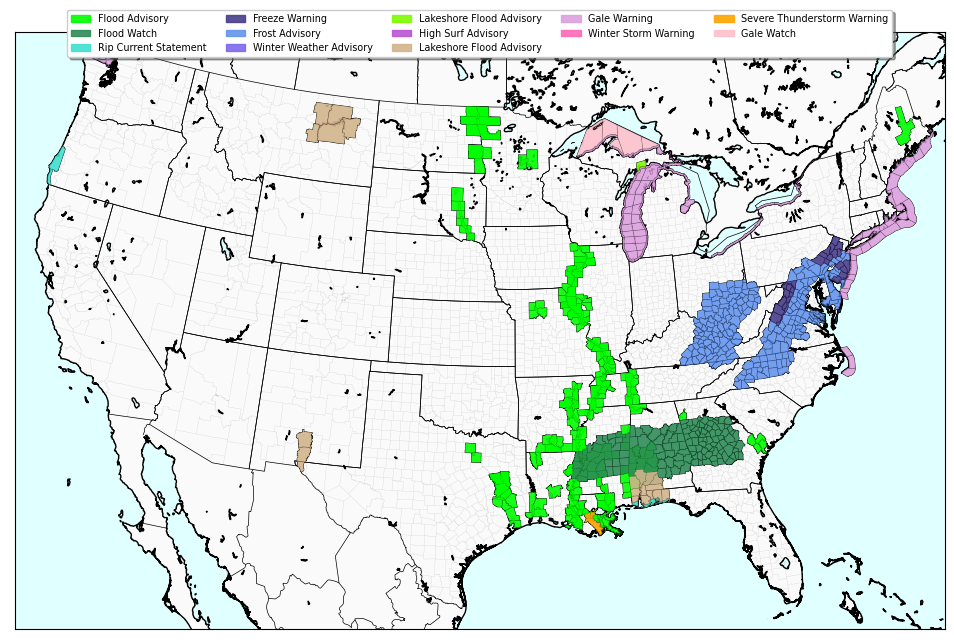

In [29]:
get_latest_shapes('IowaEnvMesonet', 'current_ww')

fig = plt.figure()
m, ax = drap_map('h', shadedrelief=False)

m.readshapefile("IowaEnvMesonet/current_ww", 'current_ww')

patches = {}
lookup=readconfig()
for info, shape in zip(m.current_ww_info, m.current_ww):
    key = f"{info['PHENOM']}{info['SIG']}"
    if key not in patches.keys():
        patches[key] = []
    patches[key].append(Polygon(np.array(shape), True))

legenditems=[]
li={}
for key in patches.keys():
    color = f"#{lookup['mapping'][key]['color']}"
    ax.add_collection(PatchCollection(patches[key],
                                      facecolor=color,
                                      edgecolor='k',
                                      label=key, alpha=.9,
                                      linewidths=.05, zorder=2))
    li[color] = lookup['mapping'][key]['name']
for color in sorted(li):
    legenditems.append(mpatches.Patch(color=color, alpha=.9, label=li[color]))

plt.legend(handles=legenditems,loc='lower center', bbox_to_anchor=(0.5, 0.95),
            fontsize='x-small',
            ncol=5, fancybox=True, shadow=True)
plt.savefig('conus_ww.png')

